In [346]:
# импортируем необходимые библиотеки
import pandas as pd 
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели  
from sklearn import metrics # инструменты для оценки точности модели  
from sklearn.model_selection import train_test_split  
from sklearn.feature_selection import f_classif # anova
import re
# читаем файл
hotels = pd.read_csv('data/hotels.csv', sep=',')
df = hotels.copy()

In [347]:
df.head(3)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,10/18/2016,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,14,7.5,"[' Leisure trip ', ' Solo traveler ', ' Modern...",289 day,48.845377,2.325643


In [348]:
print(df.duplicated().sum())
df.drop_duplicates(inplace=True)

307


## Работа с признаками
Посмотим на каждый признак в нашем датасете и посмотрим как мы можем их использовать

### hotel address 

Из признака адреса отеля можно вытащить страну в которой расположен отель, что может быть полезно и использовано в модели

In [349]:
df['hotel_country'] = df['hotel_address'].apply(lambda x: x.split(' ')[-1])
df['hotel_country'].describe()
df = pd.get_dummies(df, columns=['hotel_country'], drop_first=True) # сразу закодируем страны в которых располагаются отели
df.drop(columns=['hotel_address'], inplace=True)

### review date

Из даты отзыва можно получить месяц года в котором посетитель вероятно был в отеле 

In [350]:
df['review_date'] = df['review_date'].astype('datetime64[ms]')
df['review_month'] = df['review_date'].dt.month
df.drop(['review_date'], axis=1, inplace=True)

### hotel name
Имя отеля не редставляет для нас большого интереса, т.к имена отелей в большей своей массе уникальны 

In [351]:
df.drop(['hotel_name'], axis=1, inplace=True)

### reviewer nationality

Признак национальности рецензента может быть нам полезен, т.к. в зависимости от национальности он мог столкнуться с ряюом проблем связанных с менталитетом языковым барьером и т.д.

In [352]:
import category_encoders as ce # импорт для работы с кодировщиком
bin_encoder = ce.BinaryEncoder(cols=['reviewer_nationality']) # указываем столбец для кодирования
type_bin = bin_encoder.fit_transform(df['reviewer_nationality'])
df = pd.concat([df, type_bin], axis=1)

df.drop(['reviewer_nationality'], axis=1, inplace=True)


### days_since_review
В этом признаке нам необходимо перевести дни в числовой формат

In [353]:
df['days_since_review'] = df['days_since_review'].apply(lambda x: x.split(' ')[0])
df['days_since_review'] = df['days_since_review'].astype('int')

### tags
В тегах содержится важная информация о типе поездки, количестве ночей и наличии питомца в поездке

In [354]:
df['tags'] = df['tags'].apply(lambda x: x[3:-3].split(" ', ' "))
# создадим признак количества тегов в конкретном отзыве
df['tags_count'] = df['tags'].apply(lambda x: len(x))

Напишем функцию для распределения тегов по категориям

In [355]:
# напишем функцию для извлечения из списка необходимых значений и сразу придадим им числовые признаки
def rule(x):
    """_summary_

    Args:
        x (_type_): _string data_

    Returns:
        _type_: _tuples_
    """
    lst_1 = {'Leisure trip' : 1, 'Business trip' : 2}
    lst_2 = {'Couple' : 1, 'Solo traveler' : 2, 'Family with young children' : 4, 
             'Group' : 3, 'Family with older children' : 5, 'Travelers with friends' : 6}
    lst_3 = {'Submitted from a mobile device' : 1}
    lst_4 = {'With a pet' : 1}
    lst_5 = {'Stayed' : re.findall(r'(\d+)(?!.*\d)', str(x))}
    def circle(x, lst):
        for i in lst:
            if i in x:
                x.remove(i)
                return lst[i]
            if i in str(x):
                index = [ind for ind in range(len(x)) if x[ind].startswith('Stayed')][0]
                x.remove(x[index])
                return lst[i][0]
        return 0  
    trip_kind = circle(x, lst_1)
    travelers = circle(x, lst_2)
    submitted  = circle(x, lst_3)
    with_a_pet = circle(x, lst_4)
    nights = circle(x, lst_5)
    
    return trip_kind, travelers , submitted, with_a_pet, nights
 
df[['trip_kind', 'travelers', 'submitted', 'with_a_pet', 'nights']] = df['tags'].apply(rule).to_list()
df[['trip_kind', 'travelers', 'submitted', 'with_a_pet', 'nights']] = df[[
    'trip_kind', 'travelers', 'submitted', 'with_a_pet', 'nights']].astype('int8')

In [356]:
df.drop(['tags'], axis=1, inplace=True) # удаляем исходный признак тегов

### negative/positive review

Работа с позитивными и негативными отзывами похожа, поэтому рассмотрим оба признака в одном блоке.

In [357]:
df['negative_review'] = df['negative_review'].apply(lambda x: x.strip())
df['negative_review'] = df['negative_review'].apply(lambda x: x.lower())
df['positive_review'] = df['positive_review'].apply(lambda x: x.strip())
df['positive_review'] = df['positive_review'].apply(lambda x: x.lower())

В негативных отзывах оказалось много ложно-негативных, я создал список из наиболее популярных таких отзывов и написал функцию для щамены их на 0

In [358]:
negative_fake = ['no negative',                
'nothing',                              
'',                     
'all good',            
'nothing really',
'no complaints', 
'nothing at all', 
'none',
'n a',
'nothing to dislike', 
'can t think of anything', 
'absolutely nothing',
'nil', 
'na',
'everything was perfect',
'nothing to complain about',
'everything was great',
'no',
'nothing not to like', 
'everything was good',
'nothing all good',
'not much',
'liked everything',
'having to leave',
'i liked everything',
'nothing everything was perfect',
'non',
'see above',
'nothing it was perfect',
'everything was fine',
'nothing everything was great',
'all was good',
'nothing in particular',
'there was nothing i didn t like',
'nothing comes to mind',
'as above',
'no negatives',
'no complaints at all',
'nothing to report',
'not a thing',
'no thing',
'it was all good',
'there was nothing to dislike',
'nothing i didn t like',
'we liked everything',
'all ok',
'loved everything',
'there was nothing we didn t like',
'nothing to mention',
'no problems',
'nothing to say',
'nothing i can think of',
'no comment',
'nothing to complain',
'no issues',
'no bad experience',
'nothing bad to say',
'everything was ok',
'there was nothing not to like',
'no dislikes',
'nothing special',
'nada',
'nothing bad',
'nothing we didn t like',
'nothing could have been better',
'liked it all',
'that we had to leave',
'everything was excellent',
'all great',
'nothing to not like',
'no comments',
'nothing much',
'i loved everything',
'there wasn t anything we didn t like',
'loved it all',
'couldn t fault it',
'nothing all was good',
'nothing it was all good',
'what s not to like',
'no bad experiences',
'not a lot',
'it was perfect',
'nothing negative to say',
'going home',
'nothing it was great',
'cannot think of anything',
'that i couldn t stay longer',
'that we couldn t stay longer',
'i can t think of anything',
'nothing to add',
'nothing to fault',
'can t think of a thing',
'i have no complaints',
'nothing that i can think of',
'nothing all was great',
'all was great',
'nothing it was all great',
'no problems at all',
'nope',
'nothing of note',
'everything perfect',
'all fine',
'that i had to leave',
'nothing springs to mind',
'all was fine',
'couldn t fault anything',
'no negative comments',
'no faults',
'everything was very good',
'nothing everything was excellent',
'coming home',
'it was all great',
'nothing specific',
'there was nothing i did not like',
'i liked it all',
'there was nothing that we didn t like',
'i had to leave',
'nothing it was excellent',
'nothing all perfect',
'perfect',
'everything good',
'nothing i did not like',
'all was ok'
]    

In [359]:
df['negative_review'] = df['negative_review'].apply(lambda x: 0 if x in negative_fake else x)

Тоже самое проделаем с позитивныи отзывами, слава богу, что ложно-позитивных отзывов сильно меньше 



In [360]:
positive_fake = ['nothing', 'not much', 
                           'not a lot', 'nothing at all', 
                           'nothing really', 'none','nothing special', 'absolutely nothing',  '',
                           'no thing', 'very little',  'checking out', 'nothing much', 
                           'nothing to like', 'almost nothing', 'everything', 'nothing in particular',
                           'no', 'n a', 'not much really', 'nothing to be honest', 'not alot', 'no positive']
df['positive_review'] = df['positive_review'].apply(lambda x: 0 if x in positive_fake else x)

In [361]:
very_negative_list = [
        'everything', 'all', 'worst', 'outrageous', 'disgust', 'never', 'danger', 
        'miserable', 'horrible', 'terrible', 'rotten', 'revulsion', 'dreadful',
        'awful', 'very', 'extremely', 'definitely'     
    ]

very_positive_list = [
        'everything', 'all', 'best', 'excellent', 'outstanding', 'happiest', 
        'amazing','wonderful', 'brilliant', 'perfect', 'fantastic', 'magnificent',
        'very', 'superb', 'extremely', 'definitely', 'super', 'most' 
    ]

Теперь убрем все предлоги, союзы и слова не дающие нам понимания о минусах

In [362]:
def clean_text(text):
    """returns length of list of words in text without prepositions and speсial words

    Args:
        text (str): text

    Returns:
        (int): length list of words
    """
    
    prep_list = [
        'a', 'the', 'no', 'not', 'do', 'dont', 'does', 'doesnt', 'did', 'didnt', 
        'at', 'about', 'among', 'before', 'below', 'between', 'by', 'for', 'from', 
        'in', 'into', 'of', 'on', 'off', 'out', 'over', 'since', 'untill', 'till',
        'through', 'to', 'under', 'because', 'with', 'instead', 'above', 'against',
        'along', 'across', 'after', 'ago', 'around', 'behind', 'beside', 'and', 
        'but', 't', 'as', 'so', 'my', 'our', 'to', 'or', 'don', 'didn', 'an', 'too',
        'this', 'would', 'if', 's', 'been', 'up', 'your', 'will', 'although', 'its',
        'also', 'which', 'within', 'due', 'until', 'near', 'nearby'
        ]
    
    text = ' ' + text.lower().strip() + ' '
    
    for word in prep_list:
        word = ' ' + word + ' ' # add ' ' to find the whole word and except part of word
        text = text.replace(word, ' ')
    
      
    return len(text.split())

Заново пересчитаем слова в отзывах

In [363]:
df['review_total_negative_word_counts'] = df['negative_review'].apply(lambda x: 0 if x==0 else clean_text(x))
df['review_total_positive_word_counts'] = df['positive_review'].apply(lambda x: 0 if x==0 else clean_text(x))



Также будем считать, что отсутвие негативного или положительного отзыва будет иметь кожфициент -1, отзывы с усилением эмоций коэфициент 1.5

In [364]:

def highly_negative_emotion(x):
    if x==0:
        return -1
    x = x.strip()
    x = list(x.split(' '))
    for words in x:
        if words in very_negative_list:
            return 2
        else:
            return 1
df['neg_emotion_ratio'] = df['negative_review'].apply(highly_negative_emotion)


In [365]:

def highly_positive_emotion(x):
    if x==0:
        return -1
    x = x.strip()
    x = list(x.split(' '))
    for words in x:
        if words in very_negative_list:
            return 2
        else:
            return 1
df['pos_emotion_ratio'] = df['positive_review'].apply(highly_positive_emotion)


In [366]:
df['review_total_negative_word_counts'][df['negative_review']==0] = 0
df['review_total_positive_word_counts'][df['positive_review']==0] = 0

/var/folders/lz/5m6cs7mn489cngww1z92zsvc0000gn/T/ipykernel_32065/156641299.py:1: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['review_total_negative_word_counts'][df['negative_review']==0] = 0
/var/folders/lz/5m6cs7mn489cngww1z92zsvc0000

Посчитаем соотношение слов в позитивных и негативных отзывах к общему количеству отзывов 

In [367]:
df['pos_ratio'] = df['review_total_positive_word_counts']/(df['review_total_negative_word_counts'] + df['review_total_positive_word_counts'])
df['neg_ratio'] = df['review_total_negative_word_counts']/(df['review_total_negative_word_counts'] + df['review_total_positive_word_counts'])
# если в каких-то строках после пересчета отсутствуют и позитивные и негативные слова то заполним эти пропуски 0
df = df.fillna(0)

In [368]:
df['pos_to_neg'] = df['review_total_positive_word_counts']/df['review_total_negative_word_counts']
df['neg_to_pos'] = df['review_total_negative_word_counts']/df['review_total_positive_word_counts']

df['pos_to_neg'][(df['review_total_negative_word_counts'] == 0) & (df['review_total_positive_word_counts']>0)] = df['review_total_positive_word_counts']
df['neg_to_pos'][(df['review_total_positive_word_counts'] == 0) & (df['review_total_negative_word_counts']>0)] = df['review_total_negative_word_counts']

df = df.fillna(0)


Также дополнительно разделим плюсы и минусы на категории. Именно эти категории выбраны т.к именно на эти критерии чаще всего жаловались посетители

In [369]:

rooms = ['room', 'bed','beds', 'bathroom', 'shower', 'wifi']
food = ['breakfast', 'restaurant', 'bar']
staff = ['staff', 'reception', 'service', 'lobby']
location = ['location', 'area', 'station', 'metro']
price = ['price']
def emo_cat(x):
    if x==0:
        return 0
    x = x.strip()
    x = list(x.split(' '))
    for words in x:
        if words in food:
            return 1
        if words in rooms:
            return 2
        if words in staff:
            return 3
        if words in location:
            return 4
        if words in price:
            return 5
        else:
            return 0 


df['neg_cat'] = df['negative_review'].apply(emo_cat)
df['pos_cat'] = df['positive_review'].apply(emo_cat)


In [370]:
df.drop(['negative_review', 'positive_review'], axis =1, inplace=True)

## lat\lng

Признаки широты и долготы имеют много пропусков и по своей сути дублируют созданный ранее признак страны 

In [371]:
df.drop(columns=['lat', 'lng'], axis=1, inplace = True)

Посмотрим на значения корреляции

In [372]:
df.corr()

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,days_since_review,hotel_country_France,hotel_country_Italy,...,travelers,submitted,with_a_pet,nights,neg_emotion_ratio,pos_emotion_ratio,pos_ratio,neg_ratio,neg_cat,pos_cat
additional_number_of_scoring,1.000000,-0.153076,0.029399,0.824494,-0.054625,-0.072210,-0.061932,0.012924,-0.252387,-0.129008,...,-0.011915,0.042974,-0.015852,-0.109809,0.047166,-0.037109,-0.072134,0.071726,0.013363,0.014984
average_score,-0.153076,1.000000,-0.115592,-0.180195,0.109670,0.036272,0.363822,-0.014361,0.008552,0.015392,...,-0.050647,0.007723,-0.000573,0.013641,-0.174960,0.095646,0.216228,-0.222294,-0.052513,-0.057197
review_total_negative_word_counts,0.029399,-0.115592,1.000000,0.035327,0.110007,0.002756,-0.389609,-0.040230,-0.020144,-0.009008,...,0.004085,-0.080755,0.003183,0.040694,0.398661,-0.076418,-0.510477,0.522432,0.023882,0.009761
total_number_of_reviews,0.824494,-0.180195,0.035327,1.000000,-0.030484,-0.025720,-0.073406,0.007909,-0.229102,0.088027,...,0.021864,0.016292,-0.008841,-0.034747,0.049445,-0.027673,-0.062659,0.063173,0.016443,0.000396
review_total_positive_word_counts,-0.054625,0.109670,0.110007,-0.030484,1.000000,0.030245,0.227435,-0.045205,0.019157,0.005594,...,-0.013529,-0.107474,0.000824,0.055363,-0.074232,0.214974,0.326392,-0.314251,-0.072683,-0.103148
total_number_of_reviews_reviewer_has_given,-0.072210,0.036272,0.002756,-0.025720,0.030245,1.000000,0.002508,0.036115,0.019454,0.072592,...,-0.014635,-0.129008,0.013307,-0.009363,0.007319,0.044490,0.020815,-0.020325,0.002957,0.007932
reviewer_score,-0.061932,0.363822,-0.389609,-0.073406,0.227435,0.002508,1.000000,0.002342,0.005945,-0.007118,...,-0.030761,0.014887,-0.001132,-0.014801,-0.420861,0.278530,0.570446,-0.583314,-0.124246,-0.099996
days_since_review,0.012924,-0.014361,-0.040230,0.007909,-0.045205,0.036115,0.002342,1.000000,0.011364,-0.009398,...,-0.027635,-0.037027,0.006585,0.001103,-0.040225,0.025728,0.025402,-0.026496,-0.006001,0.041385
hotel_country_France,-0.252387,0.008552,-0.020144,-0.229102,0.019157,0.019454,0.005945,0.011364,1.000000,-0.100617,...,0.028317,-0.009882,0.012111,0.068205,-0.021019,0.008825,0.031091,-0.030731,-0.001337,0.010528
hotel_country_Italy,-0.129008,0.015392,-0.009008,0.088027,0.005594,0.072592,-0.007118,-0.009398,-0.100617,1.000000,...,0.031650,-0.024915,0.013407,-0.014734,-0.014111,0.007006,0.019102,-0.019023,0.004831,-0.006809


## Проверка важности признаков


In [373]:
from sklearn.feature_selection import f_classif # anova

# Разделение на два массива данных, на прогнозируемый признак 
# и на остальные признаки для определения их влияния
X = df.drop(['reviewer_score'], axis = 1)
y = df['reviewer_score']
y=y.astype('int')

# Создаем список числовых признаков (на данном этапе все наши признаки числовые)
num_cols = list(df.columns)

# Удаление колонки reviewer_score
num_cols.remove('reviewer_score')

# Создание series с оценкой влияния признака
imp_num = pd.Series(f_classif(X[num_cols], y)[0], index=num_cols)
imp_num.sort_values(inplace = True)

# Создание DF на основе объекта Series
imp_num_df = pd.DataFrame(imp_num)
imp_num_df = imp_num_df.reset_index()
imp_num_df = imp_num_df.rename(columns={'index' : 'feature', 0 : 'impact'})
imp_num_df = imp_num_df.sort_values(by='impact', ascending=False)
imp_num_df = imp_num_df.reset_index().drop('index', axis=1)

imp_num_df

,feature,impact
0,neg_ratio,26728.198901
1,pos_ratio,24657.201178
2,neg_emotion_ratio,13700.098431
3,review_total_negative_word_counts,8677.420530
4,average_score,7588.683414
5,pos_emotion_ratio,4313.002537
6,review_total_positive_word_counts,2716.961148
7,neg_cat,1056.179875
8,pos_cat,809.778308
9,trip_kind,401.390784


Оставим только признаки с коэфициентом влияния больше 100

In [374]:
cols100 = list(imp_num_df['feature'][imp_num_df['impact'] > 100])

cols100.append('reviewer_score')

# df = df[cols100]


In [375]:
imp_num_df_100 = imp_num_df[imp_num_df['impact'] > 100]

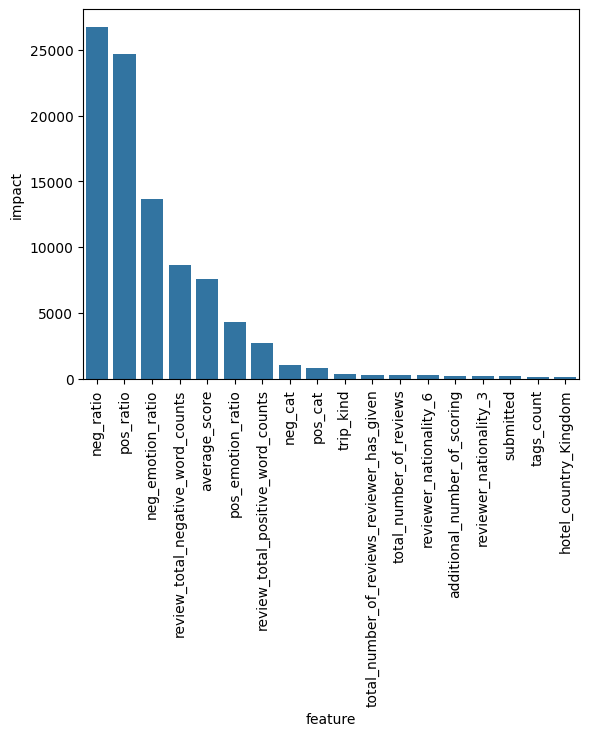

In [376]:
imp_bar = sns.barplot(imp_num_df_100, x='feature', y='impact',)
plt.xticks(rotation=90)
plt.show()

## Обучаем модель

In [377]:
# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели  
# Х - данные с информацией об отелях, у - целевая переменная (рейтинги отелей)  
X = df.drop(['reviewer_score'], axis = 1)  
y = df['reviewer_score'] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
# Создаём модель  
regr = RandomForestRegressor(n_estimators=100)  

# Обучаем модель на тестовом наборе данных  
regr.fit(X_train, y_train)  

# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.  
# Предсказанные значения записываем в переменную y_pred  
y_pred = regr.predict(X_test)  
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))


MAPE: 0.13124048176966183
